In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

This notebook demonstrates how to sequence data for a time-series problem, and then how to build deep learning and statistical models.

### Dataset

[NY DATASET](https://console.cloud.google.com/marketplace/details/city-of-new-york/nyc-311?utm_campaign=CDR_kwe_aiml_time-series-forecasting_011521&utm_source=external&utm_medium=web): This dataset shows the complaints from different locations in NYC

### Objective

The goal is to predict 311 service requests from the City of New York. These non-emergency requests include noise complaints, street light issues, etc.


## Install packages and dependencies

Restarting the kernel may be required to use new packages.

In [2]:
%pip install -U statsmodels scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


**Note:** To restart the Kernel, navigate to Kernel > Restart Kernel... on the Jupyter menu.

### Import libraries and define constants

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.cloud import storage
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, LSTM, MaxPooling1D

register_matplotlib_converters() # Address warning

In [4]:
# Enter your project, region, and a bucket name. Then run the  cell to make sure the
# Cloud SDK uses the right project for all the commands in this notebook.

PROJECT = 'optical-sight-307301' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'dl_bucket_one' # REPLACE WITH A UNIQUE BUCKET NAME e.g. your PROJECT NAME
REGION = 'us-west1-b' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
BUCKET_URI = 'gs://dl_bucket_one'

#Don't change the following command - this is to check if you have changed the project name above.
assert PROJECT != 'your-project-name', 'Don''t forget to change the project variables!'

In [5]:
# Dataset parameters

target_col = 'y' # The variable you are predicting
ts_col = 'ds' # The name of the column with the date field

In [12]:
# Model parameters

freq = 'MS' # Monthly frequency
n_input_steps = 3 # Lookback window
n_output_steps = 7 # How many steps to predict forward
n_seasons = 7 # Monthly periodicity

train_split = 0.8 # % Split between train/test data
epochs = 1000 # How many passes through the data (early-stopping will cause training to stop before this)
patience = 5 # Terminate training after the validation loss does not decrease after this many epochs

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform model version based on this output in order to serve
online predictions.

In [13]:
storage_client = storage.Client()
try:
    bucket = storage_client.get_bucket(BUCKET)
    print('Bucket exists, let''s not recreate it.')
except:
    bucket = storage_client.create_bucket(BUCKET)
    print('Created bucket: ' + BUCKET)

Bucket exists, lets not recreate it.


## Load data

In [22]:
processed_file = 'nyc_311_requests.csv' # Which file to save the results to

if os.path.exists(processed_file):
    input_file = processed_file # File created in previous lab
else:
    input_file = f'data/{processed_file}'

In [23]:
# Read data

df = pd.read_csv(input_file, index_col=ts_col, parse_dates=True)
df.index.freq = freq

df.head()

,service_date,y
ds,,
2010-01-01,0,182117
2010-02-01,1,159489
2010-03-01,2,198639
2010-04-01,3,162854
2010-05-01,4,158039


In [24]:
# Define some characteristics of the data that will be used later
n_features = len(df.columns)

# Index of target column. Used later when creating dataframes.
target_col_num = df.columns.get_loc(target_col)

In [25]:
# Split data
size = int(len(df) * train_split)
df_train, df_test = df[0:size].copy(deep=True), df[size:len(df)].copy(deep=True)

df_train.head()

,service_date,y
ds,,
2010-01-01,0,182117
2010-02-01,1,159489
2010-03-01,2,198639
2010-04-01,3,162854
2010-05-01,4,158039


## TODO 1: Remove outliers

* Sometimes, you can improve the accuracy of the model by removing outliers.
* In this lab, you'll simply remove some extremely high values.
* You can also apply techniques such as smoothing or resampling the frequency to reduce the impact of outliers.

In [26]:
df_train

,service_date,y
ds,,
2010-01-01,0,182117
2010-02-01,1,159489
2010-03-01,2,198639
2010-04-01,3,162854
2010-05-01,4,158039
...,...,...
2018-08-01,103,238695
2018-09-01,104,229118
2018-10-01,105,251578


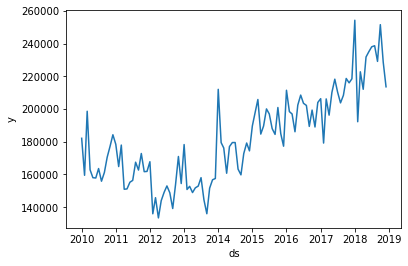

In [27]:
# Look at the highest peak. What level could you set a threshold that would clip this off?

_=sns.lineplot(data=df_train[target_col]) 

In [28]:
# Hint: here are the top 5 values

df[target_col].sort_values(ascending=False).head()

ds
2020-08-01    309696
2020-06-01    277866
2020-07-01    277210
2018-01-01    254277
2020-09-01    253049
Name: y, dtype: int64

In [29]:
# TODO: Update the threshold below to remove the outliers

threshold = 2000000 # Set this just below the level you are seeing peaks. It will flag any values above it.
assert threshold != -0.5, 'Set the threshold to the minimum that will eliminate outlier(s)'

# Set any values above the threshold to NaN (not a number)
df_train.loc[df_train[target_col] > threshold, target_col] = np.nan

# Interpolate the missing values (e.g. [3, NaN, 5] becomes [3, 4, 5])
df_train = df_train.interpolate()

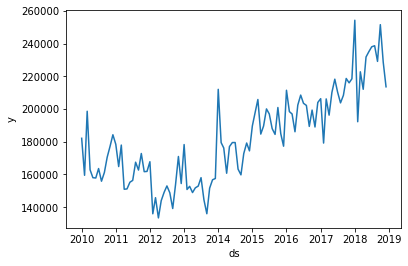

In [30]:
# Review the updated chart to see if outliers still exist
# NOTE: If you set the threshold too low, rerun starting from the 

_=sns.lineplot(data=df_train[target_col])

## Utility functions

The `Utility functions` section does **not** need thorough review.

Functions such as scaling variables, creating a time-series sequence, etc. are provided here.

### Scale the inputs and outputs

In [31]:
# For neural networks to converge quicker, it is helpful to scale the values.
# For example, each feature might be transformed to have a mean of 0 and std. dev. of 1.
#
# You are working with a mix of features, input timesteps, output horizon, etc.
# which don't work out-of-the-box with common scaling utilities.
# So, here are a couple wrappers to handle scaling and inverting the scaling.

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

def scale(df, 
          fit=True, 
          target_col=target_col,
          feature_scaler=feature_scaler,
          target_scaler=target_scaler):
    """
    Scale the input features, using a separate scaler for the target.
    
    Parameters: 
    df (pd.DataFrame): Input dataframe
    fit (bool): Whether to fit the scaler to the data (only apply to training data)
    target_col (pd.Series): The column that is being predicted
    feature_scaler (StandardScaler): Scaler used for features
    target_scaler (StandardScaler): Scaler used for target
      
    Returns: 
    df_scaled (pd.DataFrame): Scaled dataframe   
    """    
    
    target = df[target_col].values.reshape(-1, 1)
    if fit:
        target_scaler.fit(target)
    target_scaled = target_scaler.transform(target)
    
    # Select all columns other than target to be features
    features = df.loc[:, df.columns != target_col].values
    
    if features.shape[1]:  # If there are any features
        if fit:
            feature_scaler.fit(features)
        features_scaled = feature_scaler.transform(features)
        
        # Combine target and features into one data frame
        df_scaled = pd.DataFrame(features_scaled)
        target_col_num = df.columns.get_loc(target_col)
        df_scaled.insert(target_col_num, target_col, target_scaled)
        df_scaled.columns = df.columns        
    
    else:  # If only target column (no additional features)
        df_scaled = pd.DataFrame(target_scaled, columns=df.columns)
      
    return df_scaled

def inverse_scale(data, target_scaler=target_scaler):
    """
    Transform the scaled values of the target back into their original form.
    The features are left alone, as we're assuming that the output of the model only includes the target.
    
    Parameters: 
    data (np.array): Input array
    target_scaler (StandardScaler): Scaler used for target
      
    Returns: 
    data_scaled (np.array): Scaled array   
    """    
    
    df = pd.DataFrame()
    data_scaled = np.empty([data.shape[1], data.shape[0]])
    for i in range(data.shape[1]):
        data_scaled[i] = target_scaler.inverse_transform(data[:,i])
    return data_scaled.transpose()

df_train_scaled=scale(df_train)
df_test_scaled=scale(df_test, False)

### Create sequences of time-series data

In [32]:
def reframe(data, n_input_steps = n_input_steps, n_output_steps = n_output_steps, target_col = target_col):

    target_col_num = data.columns.get_loc(target_col)    
    
    # Iterate through data and create sequences of features and outputs
    df = pd.DataFrame(data)
    cols=list()
    for i in range(n_input_steps, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_output_steps):
        cols.append(df.shift(-i))
        
    # Concatenate values and remove any missing values
    df = pd.concat(cols, axis=1)
    df.dropna(inplace=True)
    
    # Split the data into feature and target variables
    n_feature_cols = n_input_steps * n_features
    features = df.iloc[:,0:n_feature_cols]
    target_cols = [i for i in range(n_feature_cols + target_col_num, n_feature_cols + n_output_steps * n_features, n_features)]
    targets = df.iloc[:,target_cols]

    return (features, targets)

X_train_reframed, y_train_reframed = reframe(df_train_scaled)
X_test_reframed, y_test_reframed = reframe(df_test_scaled)

### Evaluate results

In [33]:
def print_stats(timestep, y_true, y_pred, target_col, chart=True, table=False, dec=3):
    '''
    Helper function to print overall summary statistics and stats for each time step
    '''
    
    # Print summary statistics
    print('=== t+' + str(timestep) + ' ===')
    print('R^2:  ' + str(np.round(r2_score(y_true, y_pred), dec)))
    print('MAPE: ' + str(np.round(mean_absolute_percentage_error(y_true, y_pred), dec)))
    print('MAE:  ' + str(np.round(mean_absolute_error(y_true, y_pred), dec)))
    print('')

    df_y_true = pd.DataFrame(y_true)
    df_y_true[target_col + '_pred'] = np.round(y_pred, dec)
    
    # Show plot of actuals vs predictions and a sample of values
    if table:
        print(str(df_y_true.head(5)) + '\n')
        print(str(df_y_true.tail(5)) + '\n')
    if chart:
        sns.lineplot(data=df_y_true[[target_col, target_col+'_pred']])
        plt.show()
        
def evaluate(y_pred,
             exclude_timesteps=n_input_steps,
             y_true=df_test,
             target_col=target_col):
    '''
    Helper function to transform predictions to match size and indices of actuals.
    
    For example, n_timesteps from the test data will be required to make a prediction,
    so the number of predictions will be fewer than the number of test samples.
    
    Parameters:
    y_pred (np.array): Predictions
    exclude_timesteps (int): Number of leading timesteps to trim from the dataset
    y_true (pd.DataFrame): Actuals
    '''
        
    # Number of outputs (future timesteps)
    outputs = y_pred.shape[1]
    
    target_col_num = df.columns.get_loc(target_col)
    
    # Lists of actual and predicted values for each time step
    # For example, y_true_eval[2] will contain actual values 3 time steps out
    # These specific lists enable computing the accuracy for specific time steps
    y_true_eval, y_pred_eval = list(), list()

    # Actual and predicted values combined across all time steps (to compute overall accuracy metrics)
    y_true_all, y_pred_all = np.array([]), np.array([])
    
    # Append entries to lists for each output timestep
    for t in range(outputs):
        if exclude_timesteps:
            y_true_eval.append(y_true[exclude_timesteps+t:len(y_true)-outputs+t+1].copy())
            y_pred_eval.append(y_pred[:,t])          
        else:
            y_true_eval.append(y_true[t:].copy())
            y_pred_eval.append(y_pred[:-1*t-1,t])
        # Append the output values to the combined lists
        y_true_all = np.concatenate([y_true_all, y_true_eval[t].values[:,target_col_num]], axis=0)
        y_pred_all = np.concatenate([y_pred_all, y_pred_eval[t]], axis=0)

    # Print aggregate statistics across all time steps (only if predicting multiple time steps)
    if outputs > 1:
        print_stats('(1-' + str(outputs) + ')', y_true_all, y_pred_all, target_col, False)

    # Print stats for each future time step
    for t in range(outputs):    
        print_stats(t+1, y_true_eval[t][target_col], y_pred_eval[t], target_col, True)

## ML Models

In this section, you will build models using popular neural network architectures for time-series data.

### Long Short Term Memory (LSTM)

In [34]:
# Reshape test data to match model inputs and outputs

X_train = X_train_reframed.values.reshape(-1, n_input_steps, n_features)
X_test = X_test_reframed.values.reshape(-1, n_input_steps, n_features)
y_train = y_train_reframed.values.reshape(-1, n_output_steps, 1)
y_test = y_test_reframed.values.reshape(-1, n_output_steps, 1)

#### TODO 2: Update the LSTM architecture

Try increasing and decreasing the number of LSTM units and see if you notice any accuracy improvements.

You can use hyper-parameter tuning to search for optimal values, but that's outside the scope of this lab.

In [35]:
# Try increasing and decreasing the number of LSTM units and see if you notice any accuracy improvements.
# Run the next cell to evaluate the results in more detail.

model = Sequential([
    LSTM(64, input_shape=[n_input_steps, n_features]),
    Dense(n_output_steps)])

model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
_ = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])

Epoch 1/1000
4/4 [==============================] - 1s 191ms/step - loss: 0.8473 - val_loss: 1.4643
Epoch 2/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.8212 - val_loss: 1.4601
Epoch 3/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.7965 - val_loss: 1.4569
Epoch 4/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.7728 - val_loss: 1.4568
Epoch 5/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.7485 - val_loss: 1.4585
Epoch 6/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.7239 - val_loss: 1.4616
Epoch 7/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.6987 - val_loss: 1.4662
Epoch 8/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.6729 - val_loss: 1.4721
Epoch 9/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.6449 - val_loss: 1.4815


In [36]:
# Try increasing and decreasing the number of LSTM units and see if you notice any accuracy improvements.
# Run the next cell to evaluate the results in more detail.

model1 = Sequential([
    LSTM(32, input_shape=[n_input_steps, n_features]),
    Dense(n_output_steps)])

model1.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
_ = model1.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])

Epoch 1/1000
4/4 [==============================] - 1s 180ms/step - loss: 0.8472 - val_loss: 1.4690
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.8316 - val_loss: 1.4685
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8165 - val_loss: 1.4684
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8019 - val_loss: 1.4685
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7871 - val_loss: 1.4686
Epoch 6/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.7729 - val_loss: 1.4692
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7583 - val_loss: 1.4699
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7428 - val_loss: 1.4713


In [37]:
# Try increasing and decreasing the number of LSTM units and see if you notice any accuracy improvements.
# Run the next cell to evaluate the results in more detail.
32
model2 = Sequential([
    LSTM(128, input_shape=[n_input_steps, n_features]),
    Dense(n_output_steps)])

model2.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
_ = model2.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])

Epoch 1/1000
4/4 [==============================] - 1s 180ms/step - loss: 0.8174 - val_loss: 1.4606
Epoch 2/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.7728 - val_loss: 1.4664
Epoch 3/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.7312 - val_loss: 1.4741
Epoch 4/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.6906 - val_loss: 1.4824
Epoch 5/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.6492 - val_loss: 1.4949
Epoch 6/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.6061 - val_loss: 1.5180


In [38]:
model.save('./lstm_export/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./lstm_export/assets


In [39]:
model2.save('./lstm_export/')

INFO:tensorflow:Assets written to: ./lstm_export/assets


=== t+(1-7) ===
R^2:  -0.102
MAPE: 0.191
MAE:  40733.435

=== t+1 ===
R^2:  -0.004
MAPE: 0.191
MAE:  40889.31



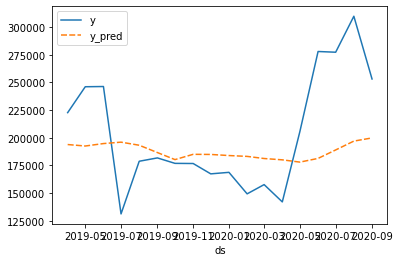

=== t+2 ===
R^2:  -0.11
MAPE: 0.196
MAE:  42853.054



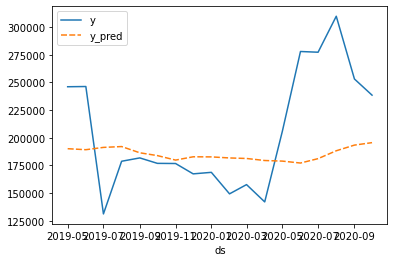

=== t+3 ===
R^2:  -0.053
MAPE: 0.209
MAE:  42951.475



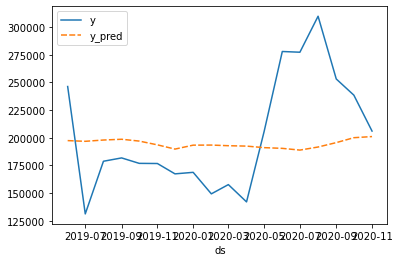

=== t+4 ===
R^2:  -0.055
MAPE: 0.21
MAE:  41679.754



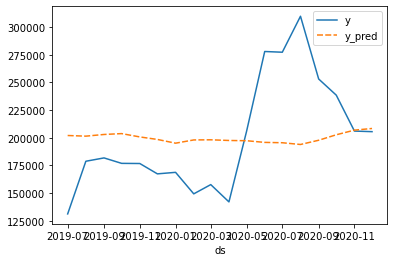

=== t+5 ===
R^2:  -0.253
MAPE: 0.169
MAE:  38312.025



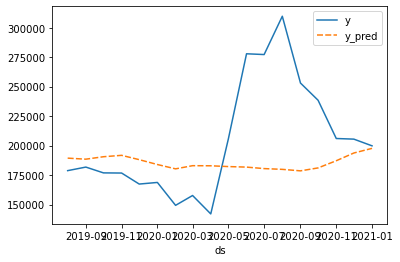

=== t+6 ===
R^2:  -0.131
MAPE: 0.177
MAE:  38657.549



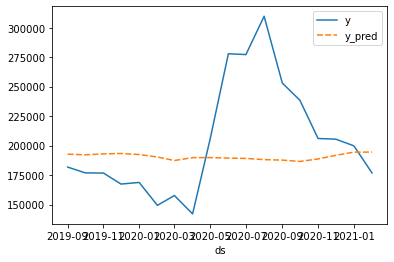

=== t+7 ===
R^2:  -0.145
MAPE: 0.184
MAE:  39790.878



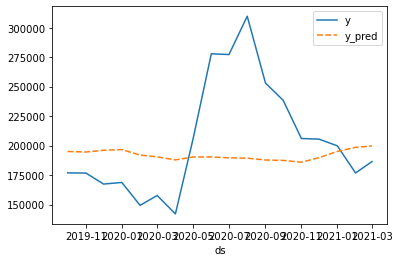

In [42]:
# Predict the results, and then reverse the transformation that scaled all values to a mean of 0 and std. dev. of 1
preds = model.predict(X_test)
y_pred_lstm = inverse_scale(preds)

# Evaluate the overall results and for each time step
evaluate(y_pred_lstm)

# The plot will show the R^2 value (0 lowest -> 1 highest) and the MAE (mean absolute error) for the entire prediction window.
# It will also show individual plots for 1 day out, 2 days out, etc. comparing the actual vs the predicted value.

=== t+(1-7) ===
R^2:  -0.073
MAPE: 0.201
MAE:  41737.312

=== t+1 ===
R^2:  -0.004
MAPE: 0.205
MAE:  42839.273



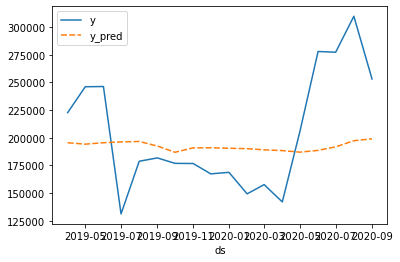

=== t+2 ===
R^2:  0.018
MAPE: 0.214
MAE:  43688.783



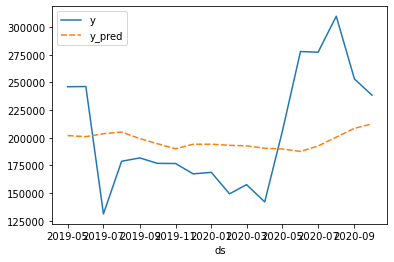

=== t+3 ===
R^2:  -0.039
MAPE: 0.213
MAE:  43202.305



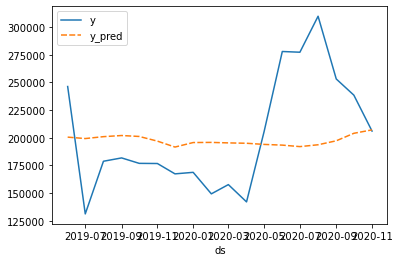

=== t+4 ===
R^2:  -0.126
MAPE: 0.221
MAE:  43944.394



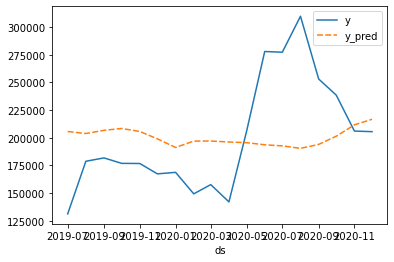

=== t+5 ===
R^2:  -0.205
MAPE: 0.179
MAE:  39240.327



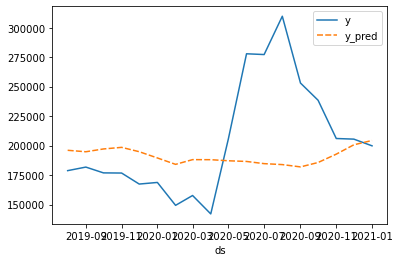

=== t+6 ===
R^2:  -0.06
MAPE: 0.183
MAE:  38563.147



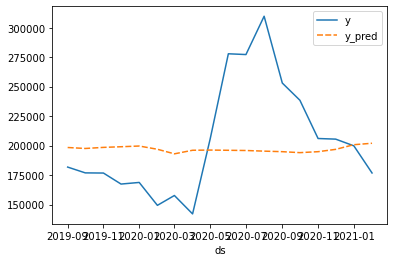

=== t+7 ===
R^2:  -0.137
MAPE: 0.192
MAE:  40682.951



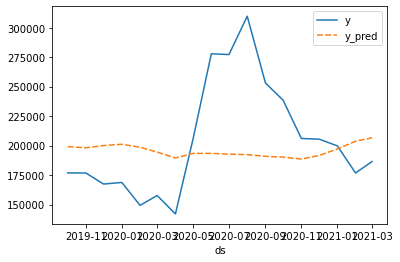

In [43]:
# Predict the results, and then reverse the transformation that scaled all values to a mean of 0 and std. dev. of 1
preds = model2.predict(X_test)
y_pred_lstm = inverse_scale(preds)

# Evaluate the overall results and for each time step
evaluate(y_pred_lstm)

# The plot will show the R^2 value (0 lowest -> 1 highest) and the MAE (mean absolute error) for the entire prediction window.
# It will also show individual plots for 1 day out, 2 days out, etc. comparing the actual vs the predicted value.

### Convolutional Neural Network (CNN)

#### TODO 3: Update the CNN architecture

Try adjusting the # of filters (pattern types) and kernel size (size of the sliding window)

In [44]:
from tensorflow.keras.layers import AveragePooling1D

# TODO: Try adjusting the # of filters (pattern types) and kernel size (size of the sliding window)
model = Sequential([
    Conv1D(filters=32, kernel_size=3, input_shape=[n_input_steps, n_features]),
    Flatten(),
    Dense(n_output_steps)])

model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
_ = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])

Epoch 1/1000
4/4 [==============================] - 0s 70ms/step - loss: 1.0705 - val_loss: 1.6871
Epoch 2/1000
4/4 [==============================] - 0s 20ms/step - loss: 1.0101 - val_loss: 1.6484
Epoch 3/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.9537 - val_loss: 1.6190
Epoch 4/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.9008 - val_loss: 1.5928
Epoch 5/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.8525 - val_loss: 1.5748
Epoch 6/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.8070 - val_loss: 1.5627
Epoch 7/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.7655 - val_loss: 1.5575
Epoch 8/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.7272 - val_loss: 1.5524
Epoch 9/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.6892 - val_loss: 1.5506
Epoch 10/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.6556 - val_loss: 1.5577
Epoch 11/

In [45]:
model.save('./cnn_export/')

INFO:tensorflow:Assets written to: ./cnn_export/assets


=== t+(1-7) ===
R^2:  -0.142
MAPE: 0.226
MAE:  44488.277

=== t+1 ===
R^2:  0.021
MAPE: 0.237
MAE:  43156.656



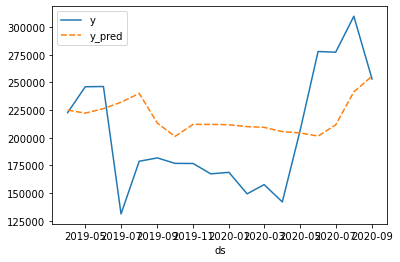

=== t+2 ===
R^2:  0.128
MAPE: 0.218
MAE:  41249.942



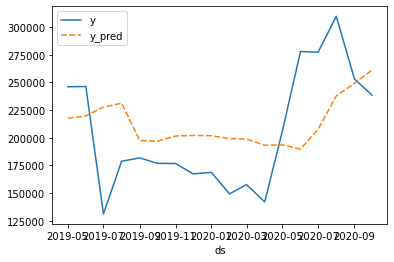

=== t+3 ===
R^2:  -0.101
MAPE: 0.266
MAE:  49023.671



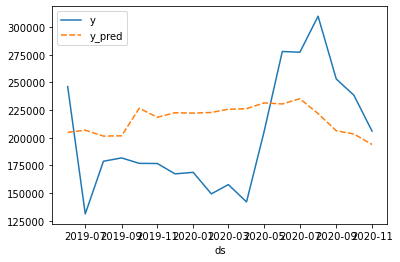

=== t+4 ===
R^2:  -0.217
MAPE: 0.236
MAE:  46549.583



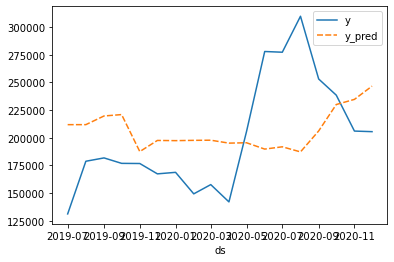

=== t+5 ===
R^2:  -0.399
MAPE: 0.247
MAE:  50293.624



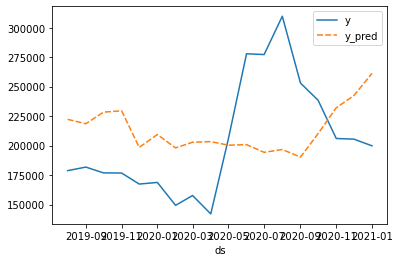

=== t+6 ===
R^2:  -0.152
MAPE: 0.214
MAE:  43129.99



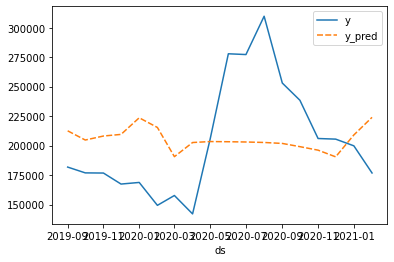

=== t+7 ===
R^2:  -0.368
MAPE: 0.161
MAE:  38014.471



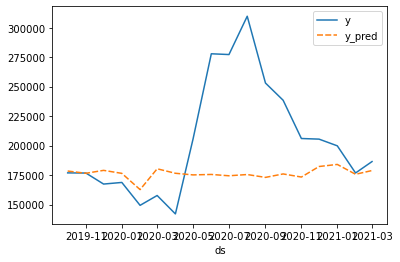

In [46]:
preds = model.predict(X_test)
y_pred_cnn = inverse_scale(preds)

evaluate(y_pred_cnn)

## Naïve Models

So-called "naïve models" can be surprisingly hard to beat. These can serve as a useful benchmark for your model's performance.

### Random Walk

Assume that future value(s) will be the same as the most recent value.

In [47]:
from statsmodels.tsa.arima.model import ARIMA

hist = df_train[target_col].copy() # Predict based on historical data. Start with the training data
hist.index.freq = pd.infer_freq(hist.index) # To avoid warnings, explicitly specify the dataframe frequency
n_pred = len(df_test) + 1 # Number of predictions: 1 on the training set; and then 1 for each additional 
y_pred_rw = np.empty([n_pred,n_output_steps]) # Create an array to hold predictions, with a number of predictions equal to the test set size, each containing the # of time steps you are predicting forward.

for t in range(n_pred):
    mod = ARIMA(hist, order=(0, 1, 0))
    res = mod.fit()
    pred = res.forecast(n_output_steps)
    y_pred_rw[t] = pred.values
    if t < n_pred - 1:
        hist.loc[df_test.iloc[t].name] = df_test[target_col][t] # Append the latest test data row to the history, for fitting the next model
        hist.index.freq = pd.infer_freq(hist.index)

=== t+(1-7) ===
R^2:  -0.955
MAPE: 0.245
MAE:  49707.315

=== t+1 ===
R^2:  0.324
MAPE: 0.125
MAE:  23922.148



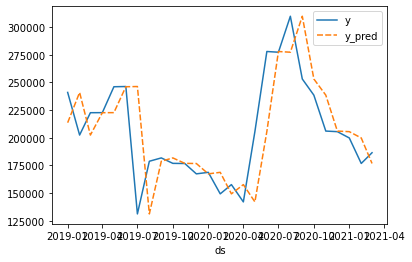

=== t+2 ===
R^2:  -0.188
MAPE: 0.172
MAE:  34661.269



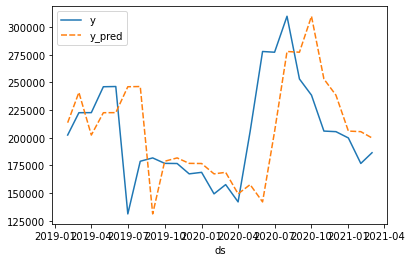

=== t+3 ===
R^2:  -0.755
MAPE: 0.226
MAE:  46762.32



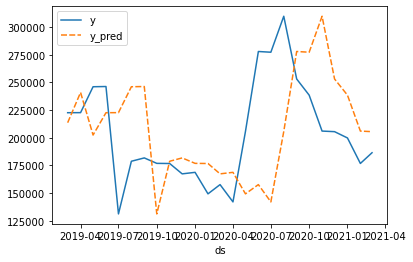

=== t+4 ===
R^2:  -1.248
MAPE: 0.265
MAE:  54915.542



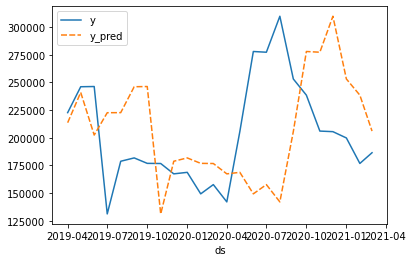

=== t+5 ===
R^2:  -1.429
MAPE: 0.299
MAE:  61634.609



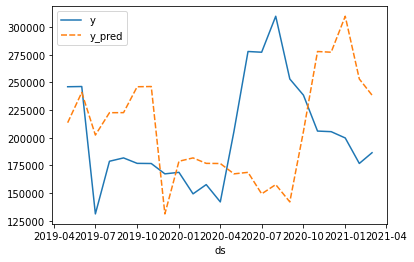

=== t+6 ===
R^2:  -1.828
MAPE: 0.334
MAE:  67102.0



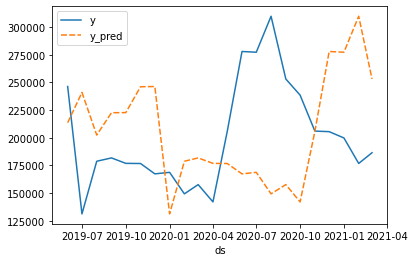

=== t+7 ===
R^2:  -1.761
MAPE: 0.338
MAE:  67755.571



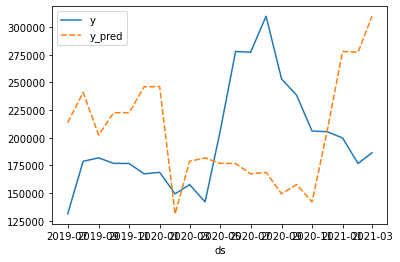

In [48]:
evaluate(y_pred_rw, 0)

## Seasonal Naïve

Similar to random walk, but instead of using the previous value, you'll use the value from the previous seasonal period. For example, if you're predicting July's forecast, you'll use last July's value, rather than June's value.

In [49]:
# You will use a walk-forward approach, in which a model is fit on all historical data available.
# As you progress through the test set to evaluate the model, you will be creating new models for each row in the test set.
# Each new model will be fit on not only the training data, but on prior test data.

from statsmodels.tsa.statespace.sarimax import SARIMAX

hist = df_train[target_col].copy() # Predict based on historical data. Start with the training data
hist.index.freq = pd.infer_freq(hist.index) # To avoid warnings, explicitly specify the dataframe frequency
n_pred = len(df_test) + 1 # Number of predictions: 1 on the training set; and then 1 for each additional 
y_pred_sn = np.empty([n_pred,n_output_steps]) # Create an array to hold predictions, with a number of predictions equal to the test set size, each containing the # of time steps you are predicting forward.

for t in range(n_pred):
    mod = SARIMAX(hist, order=(0, 0, 0), seasonal_order=(0, 1, 0, n_seasons))
    res = mod.fit()
    pred = res.forecast(n_output_steps)
    y_pred_sn[t] = pred.values
    if t < n_pred - 1:
        hist.loc[df_test.iloc[t].name] = df_test[target_col][t] # Append the latest test data row to the history, for fitting the next model
        hist.index.freq = pd.infer_freq(hist.index)

=== t+(1-7) ===
R^2:  -1.556
MAPE: 0.304
MAE:  60979.077

=== t+1 ===
R^2:  -1.467
MAPE: 0.278
MAE:  55923.889



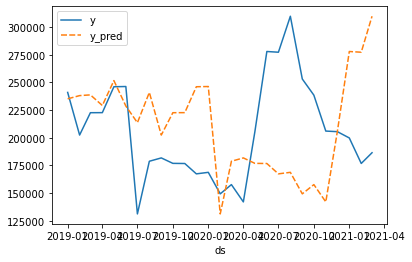

=== t+2 ===
R^2:  -1.53
MAPE: 0.288
MAE:  57852.808



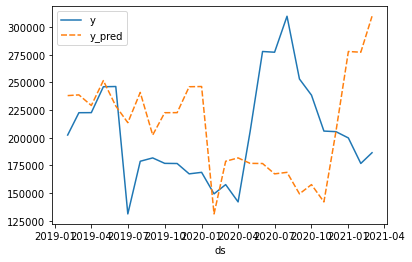

=== t+3 ===
R^2:  -1.505
MAPE: 0.292
MAE:  58742.36



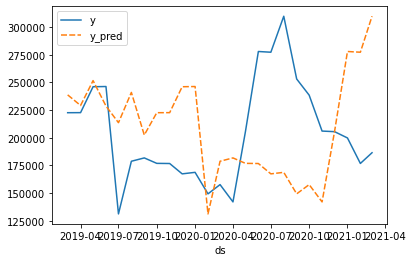

=== t+4 ===
R^2:  -1.518
MAPE: 0.301
MAE:  60519.292



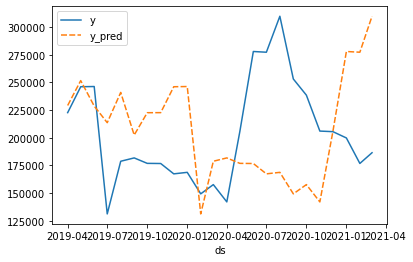

=== t+5 ===
R^2:  -1.537
MAPE: 0.313
MAE:  62869.826



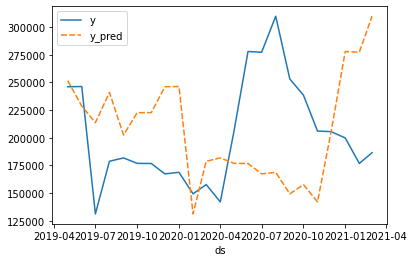

=== t+6 ===
R^2:  -1.641
MAPE: 0.326
MAE:  65476.0



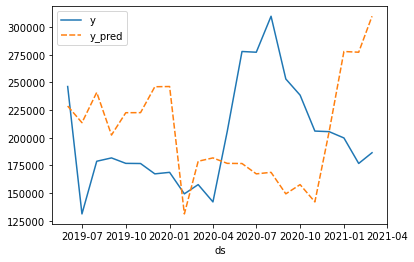

=== t+7 ===
R^2:  -1.761
MAPE: 0.338
MAE:  67755.571



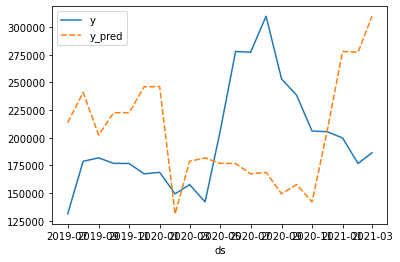

In [50]:
evaluate(y_pred_sn, 0)

## Statistical Models

You will next implement a popular statistical method for time-series analysis, *exponential smoothing*. Exponential smoothing estimates future data by weighting recent observations more heavily. The [Holt-Winters exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing) method used here uses a "triple" exponential smoothing approach that also considers trend and seasonality.

You can also ensemble classical and machine learning methods for a potentially even more accurate result.

### Exponential Smoothing

In [51]:
# You will use a walk-forward approach, in which a model is fit on all historical data available.
# As you progress through the test set to evaluate the model, you will be creating new models for each row in the test set.
# Each new model will be fit on not only the training data, but on prior test data.

hist = df_train[target_col].copy() # Predict based on historical data. Start with the training data
hist.index.freq = pd.infer_freq(hist.index) # To avoid warnings, explicitly specify the dataframe frequency
n_pred = len(df_test) + 1 # Number of predictions: 1 on the training set; and then 1 for each additional 
y_pred_es = np.empty([n_pred,n_output_steps]) # Create an array to hold predictions, with a number of predictions equal to the test set size, each containing the # of time steps you are predicting forward.

for t in range(n_pred):
    mod = ExponentialSmoothing(hist, seasonal_periods=n_seasons, trend='add', seasonal='add', damped_trend=True, use_boxcox=False, initialization_method='heuristic')
    res = mod.fit(method='L-BFGS-B')  # Use a different minimizer to avoid convergence warnings
    pred = res.forecast(n_output_steps)
    y_pred_es[t] = pred.values
    if t < n_pred - 1:
        hist.loc[df_test.iloc[t].name] = df_test[target_col][t] # Append the latest test data row to the history, for fitting the next model
        hist.index.freq = pd.infer_freq(hist.index)

=== t+(1-7) ===
R^2:  -0.913
MAPE: 0.252
MAE:  50833.426

=== t+1 ===
R^2:  0.215
MAPE: 0.14
MAE:  28132.279



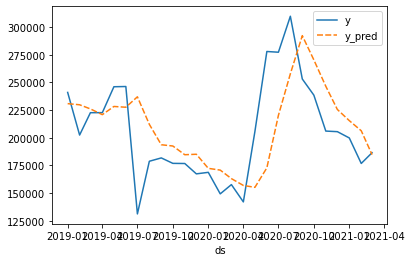

=== t+2 ===
R^2:  -0.33
MAPE: 0.187
MAE:  38407.246



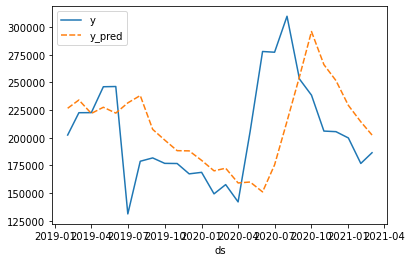

=== t+3 ===
R^2:  -0.787
MAPE: 0.232
MAE:  47659.282



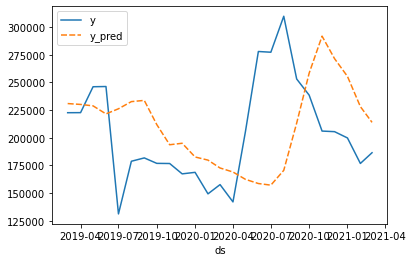

=== t+4 ===
R^2:  -1.155
MAPE: 0.269
MAE:  55071.902



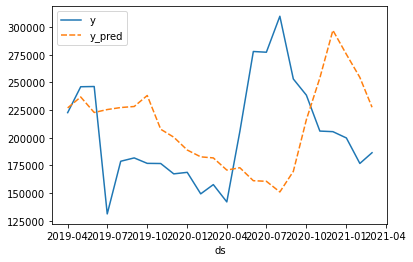

=== t+5 ===
R^2:  -1.363
MAPE: 0.302
MAE:  60987.818



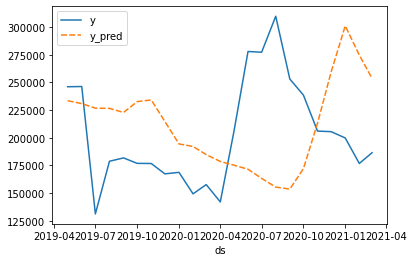

=== t+6 ===
R^2:  -1.568
MAPE: 0.33
MAE:  65446.642



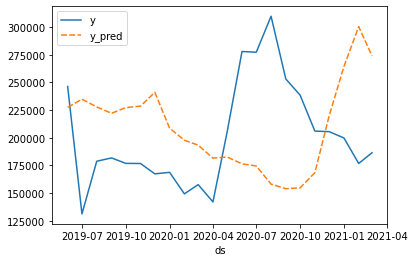

=== t+7 ===
R^2:  -1.575
MAPE: 0.347
MAE:  67909.616



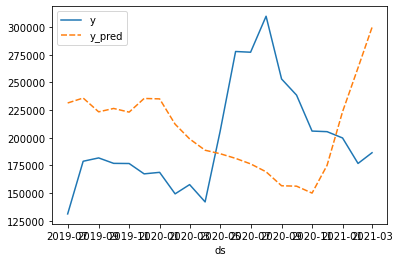

In [52]:
evaluate(y_pred_es, 0)

###  Ensemble ML and Statistical Models

If the performance of the ML and statistical models are similar, ensembling them can be helpful, because their approaches are quite different.

In [53]:
# Start by adjusting the sizes of the prediction arrays to match.
# Some methods predict the initial timesteps of the test set.
# Others start after the first sequence length.
# So, you will remove the test data that doesn't exist in both sets.

def trunc(df, test_set=df_test, n_input_steps = n_input_steps, n_output_steps = n_output_steps):
    return df[n_input_steps: -n_output_steps]

y_pred_es_trunc = trunc(y_pred_es)
y_true_trunc = trunc(df_test)

=== t+(1-7) ===
R^2:  -0.126
MAPE: 0.238
MAE:  47891.936

=== t+1 ===
R^2:  0.142
MAPE: 0.205
MAE:  40358.796



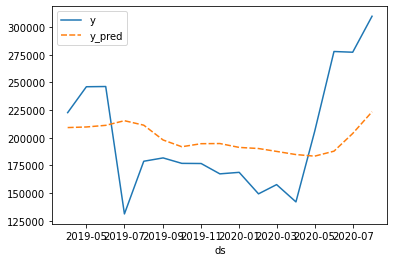

=== t+2 ===
R^2:  -0.0
MAPE: 0.225
MAE:  44709.845



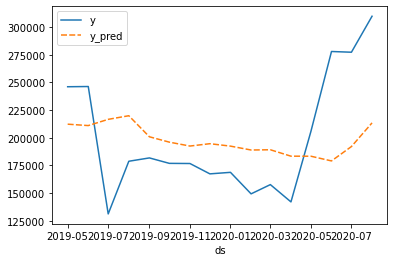

=== t+3 ===
R^2:  -0.109
MAPE: 0.25
MAE:  48707.057



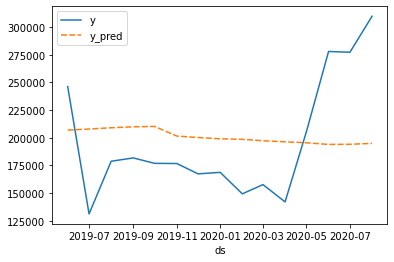

=== t+4 ===
R^2:  -0.324
MAPE: 0.265
MAE:  52041.814



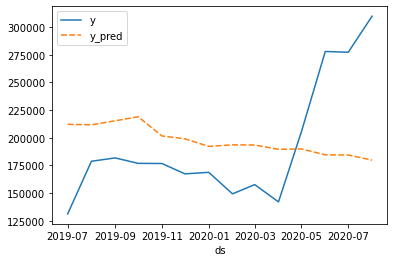

=== t+5 ===
R^2:  -0.29
MAPE: 0.238
MAE:  49913.575



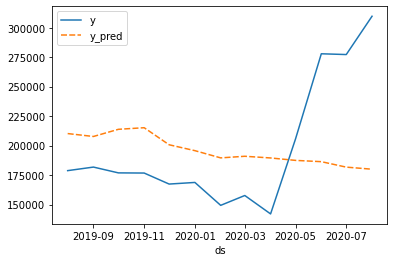

=== t+6 ===
R^2:  -0.196
MAPE: 0.249
MAE:  51121.656



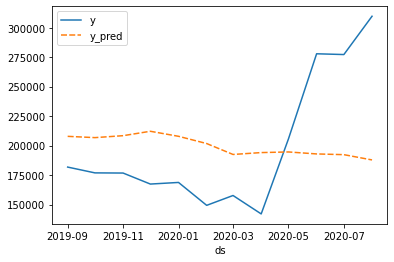

=== t+7 ===
R^2:  -0.212
MAPE: 0.243
MAE:  51856.827



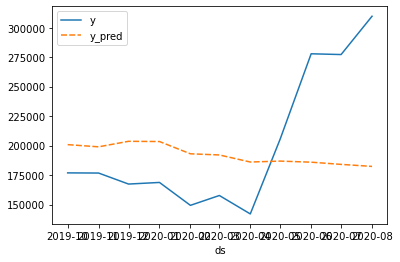

In [54]:
models = [y_pred_lstm, y_pred_cnn, y_pred_es_trunc]
weights = [2, 1, 1]

y_pred_ensemble = np.average( np.array(models), axis=0, weights=weights)

evaluate(y_pred_ensemble, 0, y_true_trunc)

## Conclusion

Great job! You've now completed the modeling portion of this workshop. You've covered:
* Removing outliers from the data
* Multi-step forecasting
* Neural network architectures for time-series forecasting: LSTM and CNN
* Statistical models, including Holt-Winters Exponential Smoothing 
* Ensembling models